# Image classification using camera trap images

Camera traps are a tool used by conservationists to study and monitor a wide range of ecologies while limiting human interference. However, they also generate a vast amount of data that quickly exceeds the capacity of humans to sift through. That's where machine learning can help! Advances in computer vision can help automate tasks like species detection and identification, so that humans can spend more time learning from and protecting these ecologies.

This notebook is an initial approach for the [Conservision Practice Area](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) challenge on DrivenData, a practice competition where you identify animal species in a real world dataset of wildlife images from [Tai National Park](https://en.wikipedia.org/wiki/Ta%C3%AF_National_Park) in Côte d'Ivoire.

![camera trap images](https://drivendata-public-assets.s3.amazonaws.com/conservision-leopard-collage.jpg)

Let's import some of the libraries we need:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

Reading in the train and test CSVs to see what they look like:

In [2]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

The `features` CSVs contain the image ID, filepath and site ID for each image. 

In [4]:
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [5]:
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

In [6]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [3]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

Exploring the Data

To see some examples of what our image data looks like, we can iterate through the list of species and selects a single random image from each species to display, along with its image ID and label.

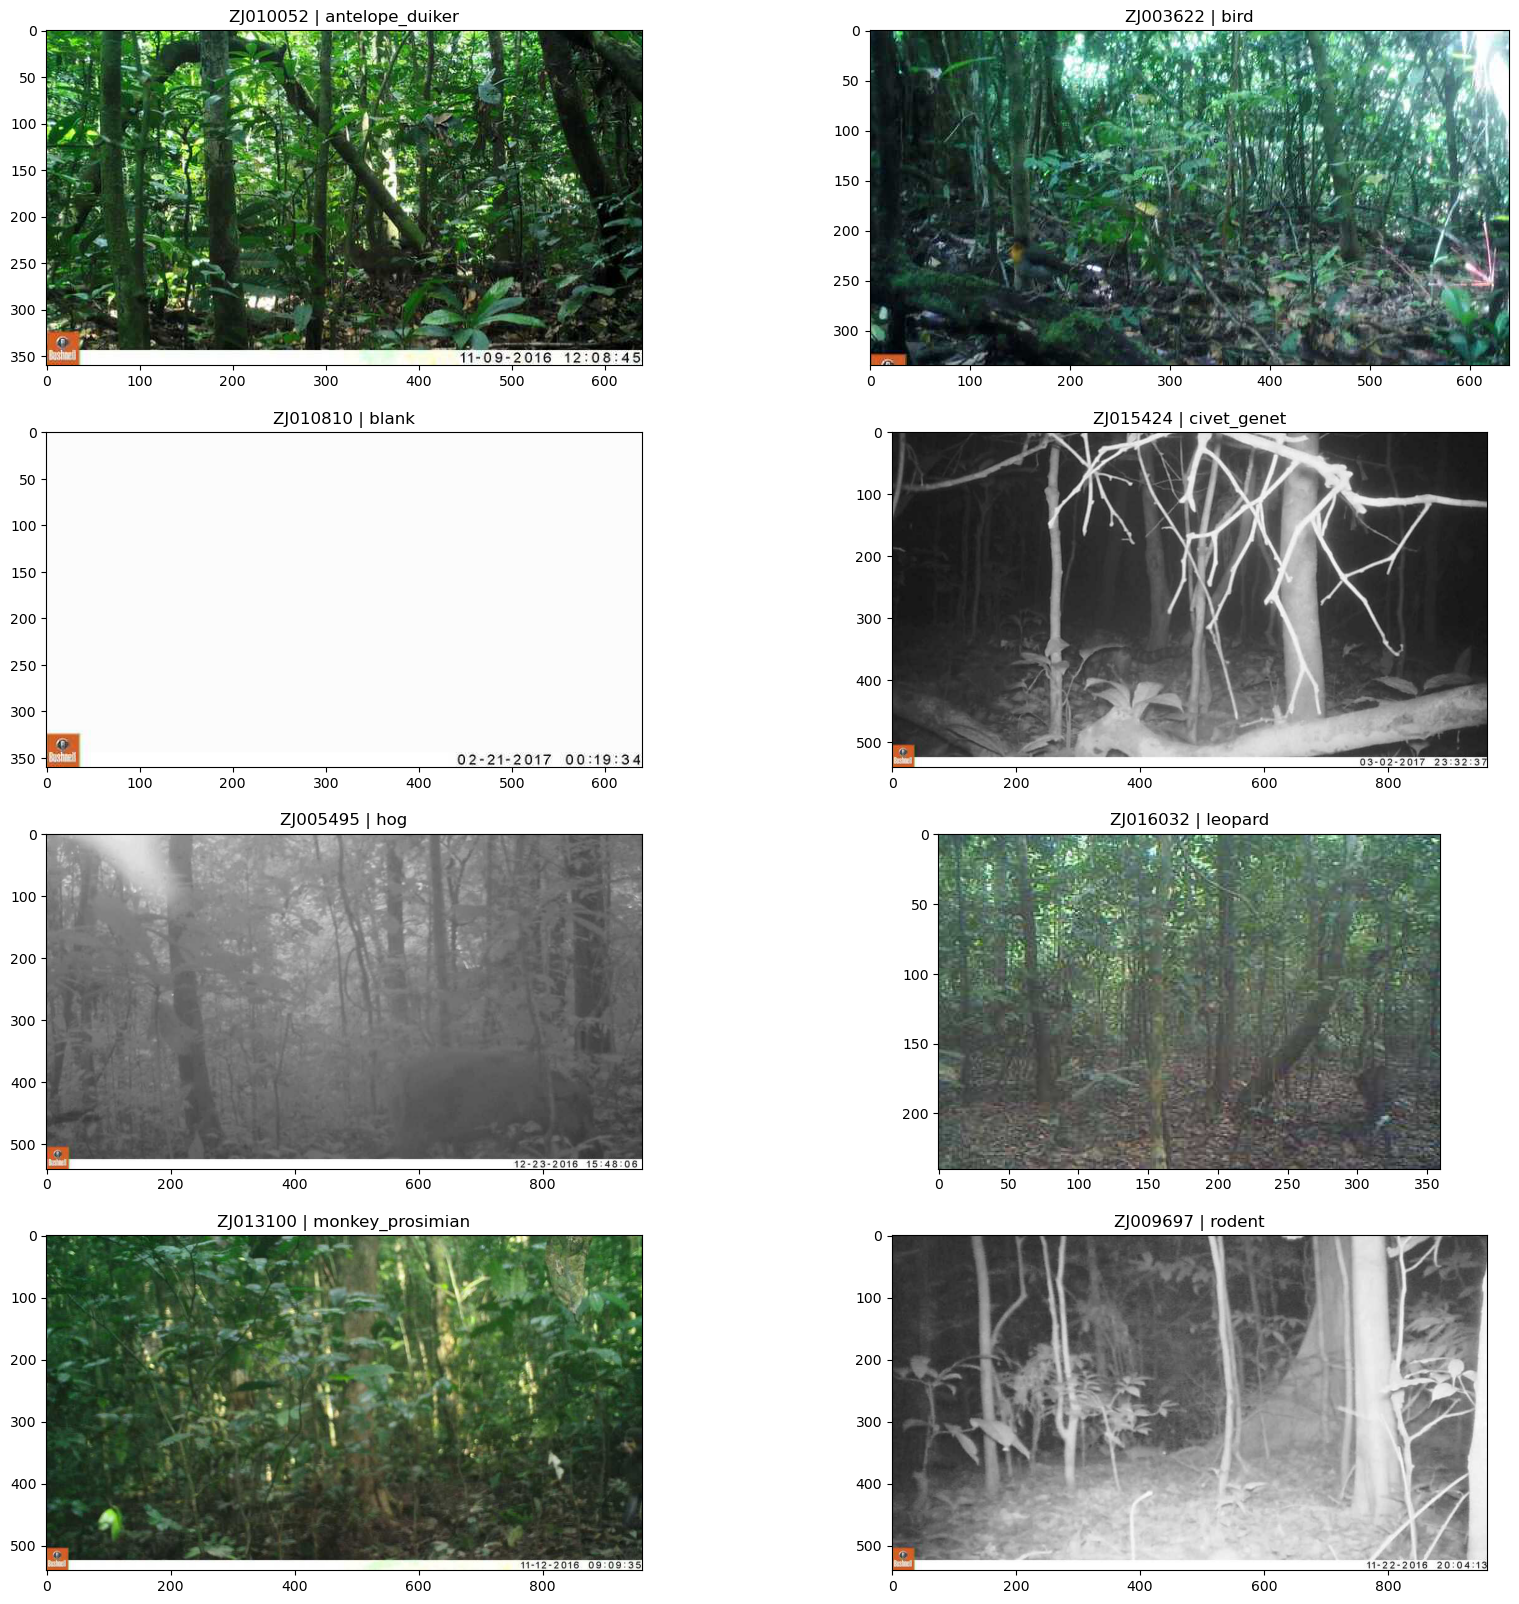

In [4]:
import matplotlib.image as mpimg

random_state = 6001

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [8]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [9]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

This distribution is not exactly what we find in the wild. The competition dataset has been curated a little bit to produce a more uniform distribution than we would see in the actual data. For additional EDA you could look at distributions of image dimensions or camera trap sites.

# Using my own GPU

In [4]:
import torch
print("CUDA available:", torch.cuda.is_available())   # Should print: True
print("CUDA version:", torch.version.cuda)             # Should print: 12.1
print("GPU name:", torch.cuda.get_device_name(0))      # Should print: NVIDIA GeForce RTX 4070
print(torch.cuda.memory_summary(device='cuda'))


CUDA available: True
CUDA version: 12.1
GPU name: NVIDIA GeForce RTX 4070
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |    

# Splitting the data for training and testing
First, we'll need to split the images into train and eval sets. We'll put aside 25% of the data for evaluation and stratify by the target labels to ensure we have similar relative frequencies of each class in the train and eval sets.

In [5]:
from sklearn.model_selection import train_test_split

frac = 0.75

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

Here's what `x_train` and `y_train` look like now:

In [12]:
x_train.head()

,filepath
id,
ZJ013850,train_features/ZJ013850.jpg
ZJ013709,train_features/ZJ013709.jpg
ZJ011678,train_features/ZJ011678.jpg
ZJ014932,train_features/ZJ014932.jpg
ZJ015040,train_features/ZJ015040.jpg


In [13]:
y_train.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ013850,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ013709,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ011678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ014932,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ZJ015040,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((9274, 1), (9274, 8), (3092, 1), (3092, 8))

Next, let's validate that our split has resulted in roughly similar relative distributions of species across the train and eval sets (because of how we passed `stratify=y` above).

In [6]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_eval.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
monkey_prosimian,15,15
antelope_duiker,15,15
civet_genet,14,14
blank,13,13
leopard,13,13
rodent,12,12
bird,9,9
hog,5,5


# Model Building

### The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((380, 380)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

Notice that we are also defining a set of **transformations**, which are defined in the `__init__` and called in the `__getitem__` special methods. These are applied to each image before returning it. Here's what each of those transformations do and why:

* `transforms.Resize((380, 380))` EfficientNet-B4 was trained on images of size 380x380 so we resize to the same dimensions here. See [pytorch docs](https://pytorch.org/vision/stable/models.html).
* `transforms.ToTensor()` converts the image to a tensor. Since we are passing in a PIL Image at this point, PyTorch can recognize it as an RGB image and will automatically convert the input values which are in the range [0, 255] to a range of [0, 1]. See more from the [PyTorch docs](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html).
* `transforms.Normalize(...)` normalizes the image tensors using the mean and standard deviation of ImageNet images. Because this transformation was applied to images when training the ResNet model, we want to do the same here with our images. See more from the [PyTorch docs on pretrained models](https://pytorch.org/vision/stable/models.html).

### The DataLoader
Next, we need to load the dataset into a dataloader. The `DataLoader` class lets us iterate through our dataset in batches.

In [8]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

The data pieces are now largely in place!

## Model Training
We decide to use the pretrained EfficientNet-B4 to maximize our possible accuracy (it is trained on higher quality images in terms of pixelation).

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks). 

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

In [9]:
from torch import nn
import timm
import gc

gc.collect()
torch.cuda.empty_cache()

model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=8)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)
model.to("cuda")
print(next(model.parameters()).device)
print(torch.cuda.memory_summary(device='cuda'))

cuda:0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  70411 KiB |  70411 KiB |  70411 KiB |      0 B   |
|       from large pool |  44096 KiB |  44096 KiB |  44096 KiB |      0 B   |
|       from small pool |  26315 KiB |  26315 KiB |  26315 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |  70411 KiB |  70411 KiB |  70411 KiB |      0 B   |
|       from large pool |  44096 KiB |  44096 KiB |  4409

### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

def lr_lambda(epoch):
    if epoch < 5:
        return float(epoch+1) / 5
    return 1.0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # change lr during training to experiment with convergence speed, change weight_decay=.0001 to help prevent overfitting
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

### Train the model
We're now ready to train our model!

We'll start simple and just run it for one epoch, but feel free to run it for more `num_epochs` if you've got the time. We hope to see a decreasing loss as training progresses, which will provide some evidence that the model is learning. Note that we haven't frozen any weights in the pretrained model, a choice which you may want to revisit and we discuss in a little more detail below.

For each epoch we'll iterate through the batches, and for each batch we'll do the following:
1. Zero out the gradients. PyTorch will sum the gradients from past batches when doing its backward pass, so in order to make sure we are only using the gradients computed for the current batch, we zero out the gradients at the beginning of each batch.
2. Run the forward pass.
3. Compute the loss and track it.
4. Compute our gradients and update our weight parameters.

In [12]:
from torch.amp import autocast, GradScaler

num_epochs = 1
tracking_loss = {}

# Free up memory before training
gc.collect()
torch.cuda.empty_cache()

# Use AMP for faster training & lower memory usage
scaler = GradScaler(device="cuda")

model.train()  # Set model to training mode

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    for batch_n, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        images = batch["image"].to("cuda", non_blocking=True)
        labels = batch["label"].to("cuda", non_blocking=True)

        optimizer.zero_grad()

        # AMP autocast context
        with autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Log loss
        tracking_loss[(epoch, batch_n)] = float(loss.item())

        # Scale loss, backprop, optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


Starting epoch 1


100%|██████████| 580/580 [02:03<00:00,  4.70it/s]


Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

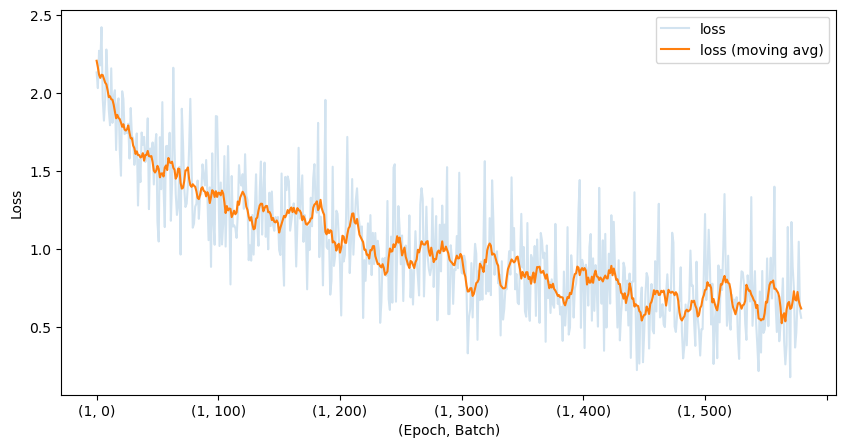

In [13]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

### Save the model

In [14]:
torch.save(model, "model.pth")

# Evaluation 

In [15]:
loaded_model = torch.load("model.pth")

C:\Users\wanns\AppData\Local\Temp\ipykernel_7616\453570178.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("model.pth")


We create the eval dataset and dataloader just like we did earlier with the training dataset and dataloader:

In [16]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

### Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1]. 
3. Store the results in a dataframe for further analysis

In [19]:
preds_collector = []

model.eval()

with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        inputs = batch["image"].to("cuda", non_blocking=True)
        logits = model(inputs)
        preds = nn.functional.softmax(logits, dim=1)
        preds_df = pd.DataFrame(
            preds.detach().cpu().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 97/97 [00:28<00:00,  3.38it/s]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ010401,0.000024,0.000045,0.000059,0.000020,0.000001,0.999827,0.000003,0.000020
ZJ008981,0.004127,0.000074,0.001881,0.965973,0.000411,0.000043,0.000098,0.027393
ZJ013850,0.156084,0.032675,0.537647,0.000765,0.006943,0.005897,0.153573,0.106417
ZJ006988,0.003895,0.012795,0.004879,0.001427,0.006219,0.002829,0.703676,0.264280
ZJ007104,0.001230,0.000543,0.006884,0.000027,0.000225,0.000392,0.979421,0.011278
...,...,...,...,...,...,...,...,...
ZJ003749,0.009783,0.001852,0.031154,0.005556,0.000379,0.000926,0.000186,0.950163
ZJ009086,0.007911,0.000473,0.004265,0.000095,0.002911,0.000387,0.982343,0.001615
ZJ016400,0.107909,0.036438,0.230150,0.000941,0.003982,0.028133,0.444722,0.147724
ZJ001141,0.873359,0.003719,0.015134,0.000432,0.019935,0.001866,0.082537,0.003018


### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [20]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    1422
antelope_duiker     1392
civet_genet         1383
blank               1264
leopard             1258
rodent              1122
bird                 905
hog                  528
Name: count, dtype: int64

Here's the distribution of our predictions on the eval set. 

In [21]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    608
civet_genet         462
rodent              436
leopard             425
antelope_duiker     381
blank               338
bird                270
hog                 172
Name: count, dtype: int64

The actual evaluation set is more evenly distributed than our predictions, so we already know there is some room for improvement here.

In [22]:
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    474
antelope_duiker     465
civet_genet         461
blank               421
leopard             419
rodent              374
bird                302
hog                 176
Name: count, dtype: int64

### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [23]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ010401             leopard
ZJ008981         civet_genet
ZJ013850               blank
ZJ006988    monkey_prosimian
ZJ007104    monkey_prosimian
dtype: object

Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). But we could construct a slightly better trivial model by always guessing the most common class ("monkey_prosimian" images in this case).

If we were to always guess that an image is `monkey_prosimian`, we could achieve accuracy of 15.8%.

In [24]:
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

np.float64(0.15329883570504527)

Let's see how our model compares. We take the species with the highest score for each image (`eval_predictions`) and compare that to the true labels.

In [25]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

np.float64(0.8033635187580854)

Let's look at the predictions from another angle. 

We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.

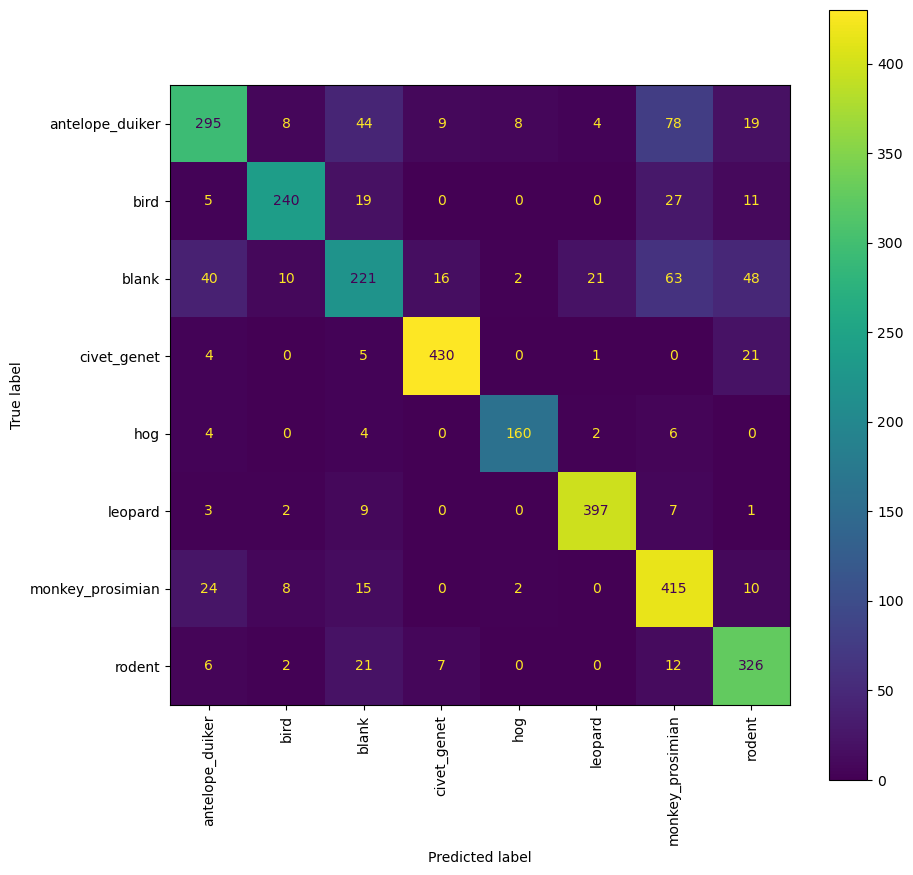

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

### THINGS TO CONSIDER

* Train for more epochs. We've only done 1 so far.
* Try another pretrained model. For example, you may have more success with EfficientNet, or another ResNet model with more layers like ResNet152. See what's available from pytorch [here](https://pytorch.org/vision/stable/models.html). You may also want to review which models are or have been state of the art for image classification tasks, for example on [paperswithcode.com](https://paperswithcode.com/task/image-classification). Keep in mind that different models will require different input and output dimensions, so you'll need to update how you construct `model` above.
* Experiment with different loss functions.
* Experiment with different learning rates or learning rate schedulers.
* Add more layers to the model head (`model.fc`).
* You also may want to consider freezing the weights in the backbone model and only training the head (`model.fc`). If this results in higher accuracy, that suggests the current approach may be overwriting the backbone weights in a problematic way. One approach here would be to train just the model head, and then unfreeze the backbone but train at a lower learning rate.
* Training will be much faster using GPUs, but you will need to make some small tweaks to the code.
* As you become more comfortable iterating through different versions of the model, you may want to try out [PyTorch Lightning](https://www.pytorchlightning.ai/) or [Lightning Flash](https://lightning-flash.readthedocs.io/en/latest/quickstart.html), which build upon PyTorch and eliminate a lot of boilerplate code, in addition to providing a more complete research framework for deep learning problems.

## Submitting to DataDriven Competition

Last but not least, we'll want to participate in the competition and see where we stand on the leaderboard.

To do this we need to create predictions for the **competition test set** (not the eval set we used above). You don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [28]:
test_dataset = ImagesDataset(test_features.filepath.to_frame())
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [31]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        # run the forward step
        inputs = batch["image"].to("cuda", non_blocking=True)
        logits = model(inputs)
        # apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().cpu().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

submission_df = pd.concat(preds_collector)
submission_df

100%|██████████| 279/279 [01:02<00:00,  4.46it/s]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.042048,0.004088,0.679075,0.160443,0.001920,0.021846,0.003183,0.087397
ZJ016489,0.599966,0.004965,0.035354,0.006516,0.240152,0.001782,0.044127,0.067138
ZJ016490,0.269165,0.002978,0.031637,0.040718,0.542749,0.034347,0.006498,0.071910
ZJ016491,0.000111,0.000056,0.000792,0.000639,0.000044,0.998167,0.000035,0.000156
ZJ016492,0.286200,0.082598,0.008372,0.005081,0.004848,0.000644,0.578944,0.033314
...,...,...,...,...,...,...,...,...
ZJ020947,0.349580,0.015315,0.122930,0.002146,0.020492,0.088801,0.383260,0.017475
ZJ020948,0.119661,0.022321,0.526887,0.003532,0.005987,0.209074,0.070794,0.041743
ZJ020949,0.426006,0.003289,0.228013,0.013233,0.036376,0.010780,0.004897,0.277405
ZJ020950,0.932719,0.001865,0.006547,0.000229,0.017204,0.001391,0.015379,0.024666


In [ ]:
# check that submission format is correct
submission_format = pd.read_csv("submission_format.csv", index_col="id")

assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

In [ ]:
submission_df.to_csv("submission_df.csv")